# Attention GAN:

This model was trained originally on CelebA. I modified it and did some experiment on my own to see if I could improve the result. The source code is available at https://github.com/Ha0Tang/AttentionGAN

In [1]:
import os
import argparse
from torch.backends import cudnn
from torch.utils import data
from torchvision import transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import random
from torchvision.utils import save_image
import time
import datetime
import matplotlib.pyplot as plt

# Create label for data set:

Our original label is 'train_label_fixed.txt' containing the name of images and their corresponding age. I need to convert them to the binary value representing their age group (similar to one-hot encoding). 

After the first model, as an attempt to improve the result, I tried extending the classes with Gender and Glasses. I downloaded the json files that has the missing information and add them to the original label list. The json files are downloaded from this repository: https://github.com/DCGM/ffhq-features-dataset

In [ ]:
import json
def create_dataset_label(infile, outfile):
    data = []
    attr = ['Age0-9', 'Age10-19', 'Age20-29', 'Age30-49', 'Age50-69', 'Age70+', 'Gender', 'ReadingGlasses', 'Sunglasses']
    with open(infile, 'r') as ifile:
        data = [line.strip().split() for line in ifile]
    #print(data)
    count = 0
    with open(outfile, 'w') as ofile:
        ofile.write('70000\n')
        for string in attr:
            ofile.write(f'{string} ')
        ofile.write('\n')
        for line in data:
            ofile.write(f'{line[0]} ')
            line_attr = [0]*len(attr) #init
            if float(line[1]) < 10:
                line_attr[attr.index('Age0-9')] = 1 #set 1
            elif float(line[1]) < 20:
                line_attr[attr.index('Age10-19')] = 1
            elif float(line[1]) < 30:
                line_attr[attr.index('Age20-29')] = 1
            elif float(line[1]) < 50:
                line_attr[attr.index('Age30-49')] = 1
            elif float(line[1]) < 70:
                line_attr[attr.index('Age50-69')] = 1
            else:
                line_attr[attr.index('Age70+')] = 1
            
            json_file = f"json/{count:05d}.json"
            with open(json_file, 'r') as image_json:
                try:
                    attr_dict = json.load(image_json)[0]
                    face_attr = attr_dict['faceAttributes']
                    if face_attr['gender'] == 'male':
                        line_attr[attr.index('Gender')] = 1
                    if face_attr['glasses'] == 'ReadingGlasses':
                        line_attr[attr.index('ReadingGlasses')] = 1
                    elif face_attr['glasses'] == 'Sunglasses':
                        line_attr[attr.index('Sunglasses')] = 1
                except:
                    pass
            count += 1

            for i in line_attr:
                ofile.write(f'{str(i)} ')
            ofile.write('\n')

create_dataset_label('data/ffhq128/train_label_fixed.txt', 'data/ffhq128/list_attr_ffhq128.txt')

# Initialize Variables:

In [ ]:
# Model configuration.
c_dim = 9    # dimension of domain labels
ffhq128_crop_size=178   # crop size for the Ffhq128 dataset
image_size=128  # image resolution
g_conv_dim=64   # number of conv filters in the first layer of G
d_conv_dim=64  # number of conv filters in the first layer of D
g_repeat_num=6  # number of residual blocks in G
d_repeat_num=6  # number of strided conv layers in D
lambda_cls=1    # weight for domain classification loss
lambda_rec=10    # weight for reconstruction loss
lambda_gp=10    # weight for gradient penalty
    
# Training configuration.
dataset='Ffhq128'
batch_size=16   #mini-batch size
num_iters=100000    #number of total iterations for training D
num_iters_decay=50000  # number of iterations for decaying lr
g_lr=0.0001 # learning rate for G
d_lr=0.0001 # learning rate for D
n_critic=5  # number of D updates per each G update
beta1=0.5   # beta1 for Adam optimizer
beta2=0.999 # beta2 for Adam optimizer
resume_iters=None   #resume training from this step
selected_attrs=['Age0-9', 'Age10-19', 'Age20-29', 'Age30-49', 'Age50-69', 'Age70+', 'Gender', 'ReadingGlasses', 'Sunglasses']

# Test configuration.
test_iters=100000   # test model from this step
test_size = 5000    # number of images in test dataset

# Miscellaneous.
num_workers=0
mode='train'  # choices=['train', 'test'])

# Directories.
ffhq128_image_dir='data/ffhq128/images'
attr_path='data/ffhq128/list_attr_ffhq128.txt'
model_save_dir='agan_ffhq128/models'
sample_dir='agan_ffhq128/samples'
result_dir='agan_ffhq128/results'

# Step size.
log_step=10 # print result
sample_step=1000 # save result
model_save_step=10000 # save model
lr_update_step=1000 # update lr

# Dataloader

I slightly modified the loader for it to work with the new dataset

In [ ]:
class Ffhq128(data.Dataset):
    """Dataset class for the Ffhq128 dataset."""

    def __init__(self, image_dir, attr_path, selected_attrs, transform, mode):
        """Initialize and preprocess the Ffhq128 dataset."""
        self.image_dir = image_dir
        self.attr_path = attr_path
        self.selected_attrs = selected_attrs
        self.transform = transform
        self.mode = mode
        self.test_size = test_size
        self.train_dataset = []
        self.test_dataset = []
        self.attr2idx = {}
        self.idx2attr = {}
        self.preprocess()

        if mode == 'train':
            self.num_images = len(self.train_dataset)
        else:
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        """Preprocess the Ffhq128 attribute file."""
        lines = [line.rstrip() for line in open(self.attr_path, 'r')]
        all_attr_names = lines[1].split()
        for i, attr_name in enumerate(all_attr_names):
            self.attr2idx[attr_name] = i
            self.idx2attr[i] = attr_name

        lines = lines[2:]
        random.seed(1234)
        random.shuffle(lines)
        for i, line in enumerate(lines):
            split = line.split()
            filename = split[0]
            values = split[1:]

            label = []
            for attr_name in self.selected_attrs:
                idx = self.attr2idx[attr_name]
                label.append(values[idx] == '1')
            

            if (i+1) < (70000 - self.test_size):
                self.train_dataset.append([filename, label])
            else:
                self.test_dataset.append([filename, label])

        print('Finished preprocessing the Ffhq128 dataset...')

    def __getitem__(self, index):
        """Return one image and its corresponding attribute label."""
        dataset = self.train_dataset if self.mode == 'train' else self.test_dataset
        filename, label = dataset[index]
        image = Image.open(os.path.join(self.image_dir, filename))
        return self.transform(image), torch.FloatTensor(label)

    def __len__(self):
        """Return the number of images."""
        return self.num_images


def get_loader(image_dir, attr_path, selected_attrs, crop_size=178, image_size=128, 
               batch_size=16, mode='train', num_workers=1):
    """Build and return a data loader."""
    transform = []
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
    transform.append(T.CenterCrop(crop_size))
    transform.append(T.Resize(image_size))
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    dataset = Ffhq128(image_dir, attr_path, selected_attrs, transform, mode)

    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  num_workers=num_workers)
    print(len(data_loader))
    return data_loader

# Define the architecture:

I first started with the original architecture and train it on our dataset. 

After getting the initial result, the model seemed to be overfitting and did not scale the facial expressions to fit the head size very well, so I tried modifying the architecture by changing InstanceNorm2d to BatchNorm2d to see if the problem of overfitting would resolve. The result was worse and the model was not able to distinguish different age groups, leading all images across different age groups to look almost similar to each other. 

I reverted the architecture to see if adding new classes (Gender and Glasses) alone could improve the result


In [ ]:
class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)


class Generator(nn.Module):
    """Generator network."""
    def __init__(self, conv_dim=64, c_dim=5, repeat_num=6):
        super(Generator, self).__init__()

        layers = []
        layers.append(nn.Conv2d(3+c_dim, conv_dim, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 3+1, kernel_size=7, stride=1, padding=3, bias=False))
        # layers.append(nn.Tanh()) # ht
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        # Replicate spatially and concatenate domain information.
        # Note that this type of label conditioning does not work at all if we use reflection padding in Conv2d.
        # This is because instance normalization ignores the shifting (or bias) effect.
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        input_image = x
        x = torch.cat([x, c], dim=1)
        # return self.main(x)
        # print(x.size())
        output = self.main(x)
        # print(output.size())
        attention_mask = F.sigmoid(output[:, :1])
        content_mask = output[:, 1:]
        attention_mask = attention_mask.repeat(1, 3, 1, 1)
        result = content_mask * attention_mask + input_image * (1 - attention_mask)
        return result, attention_mask, content_mask


class Discriminator(nn.Module):
    """Discriminator network."""
    def __init__(self, image_size=128, conv_dim=64, c_dim=5, repeat_num=6):
        super(Discriminator, self).__init__()
        layers = []
        layers.append(nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.01))

        curr_dim = conv_dim
        for i in range(1, repeat_num):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim = curr_dim * 2

        kernel_size = int(image_size / np.power(2, repeat_num))
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(curr_dim, c_dim, kernel_size=kernel_size, bias=False)
        
    def forward(self, x):
        h = self.main(x)
        out_src = self.conv1(h)
        out_cls = self.conv2(h)
        return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))

# Calculate FID:

I followed the tutorial from Kaggle:
https://www.kaggle.com/code/ibtesama/gan-in-pytorch-with-fid

In [ ]:
import torchvision.models as models
from torch.nn.functional import adaptive_avg_pool2d
from scipy import linalg
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
def calculate_activation_statistics(images,model,batch_size=16, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_frechet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.to(device)

c:\Users\quang\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\quang\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Define train and test functions:

I had to modify many functions including create labels, train, test, ... for it to work with the new dataset. I also added the decayed learning rate, plot and fid score calculation to the train and test function

In [ ]:
class Solver(object):
    """Solver for training and testing AttentionGAN."""

    def __init__(self, ffhq128_loader):
        """Initialize configurations."""

        # Data loader.
        self.ffhq128_loader = ffhq128_loader

        # Model configurations.
        self.c_dim = c_dim
        self.image_size = image_size
        self.g_conv_dim = g_conv_dim
        self.d_conv_dim = d_conv_dim
        self.g_repeat_num = g_repeat_num
        self.d_repeat_num = d_repeat_num
        self.lambda_cls = lambda_cls
        self.lambda_rec = lambda_rec
        self.lambda_gp = lambda_gp

        # Training configurations.
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_iters = num_iters
        self.num_iters_decay = num_iters_decay
        self.g_lr = g_lr
        self.d_lr = d_lr
        self.n_critic = n_critic
        self.beta1 = beta1
        self.beta2 = beta2
        self.resume_iters = resume_iters
        self.selected_attrs = selected_attrs

        # Test configurations.
        self.test_iters = test_iters

        # Miscellaneous.
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(self.device)

        # Directories.
        self.sample_dir = sample_dir
        self.model_save_dir = model_save_dir
        self.result_dir = result_dir

        # Step size.
        self.log_step = log_step
        self.sample_step = sample_step
        self.model_save_step = model_save_step
        self.lr_update_step = lr_update_step

        # Build the model and tensorboard.
        self.build_model()

    def build_model(self):
        """Create a generator and a discriminator."""
        if self.dataset in ['Ffhq128']:
            self.G = Generator(self.g_conv_dim, self.c_dim, self.g_repeat_num)
            self.D = Discriminator(self.image_size, self.d_conv_dim, self.c_dim, self.d_repeat_num) 

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.g_lr, [self.beta1, self.beta2])
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.d_lr, [self.beta1, self.beta2])
        self.print_network(self.G, 'G')
        self.print_network(self.D, 'D')
            
        self.G.to(self.device)
        self.D.to(self.device)

    def print_network(self, model, name):
        """Print out the network information."""
        num_params = 0
        for p in model.parameters():
            num_params += p.numel()
        print(model)
        print(name)
        print("The number of parameters: {}".format(num_params))

    def restore_model(self, resume_iters):
        """Restore the trained generator and discriminator."""
        print('Loading the trained models from step {}...'.format(resume_iters))
        G_path = os.path.join(self.model_save_dir, '{}-G.ckpt'.format(resume_iters))
        D_path = os.path.join(self.model_save_dir, '{}-D.ckpt'.format(resume_iters))
        self.G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
        self.D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))

    def update_lr(self, g_lr, d_lr):
        """Decay learning rates of the generator and discriminator."""
        for param_group in self.g_optimizer.param_groups:
            param_group['lr'] = g_lr
        for param_group in self.d_optimizer.param_groups:
            param_group['lr'] = d_lr

    def reset_grad(self):
        """Reset the gradient buffers."""
        self.g_optimizer.zero_grad()
        self.d_optimizer.zero_grad()

    def denorm(self, x):
        """Convert the range from [-1, 1] to [0, 1]."""
        out = (x + 1) / 2
        return out.clamp_(0, 1)

    def gradient_penalty(self, y, x):
        """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
        weight = torch.ones(y.size()).to(self.device)
        dydx = torch.autograd.grad(outputs=y,
                                   inputs=x,
                                   grad_outputs=weight,
                                   retain_graph=True,
                                   create_graph=True,
                                   only_inputs=True)[0]

        dydx = dydx.view(dydx.size(0), -1)
        dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
        return torch.mean((dydx_l2norm-1)**2)


    def create_labels(self, c_org, c_dim=9, dataset='Ffhq128', selected_attrs=None):
        """Generate target domain labels for debugging and testing."""
        # Get age indices.
        if dataset == 'Ffhq128':
            age_indices = []
            glasses_indices = []
            for i, attr_name in enumerate(selected_attrs):
                if attr_name in ['Age0-9', 'Age10-19', 'Age20-29', 'Age30-49', 'Age50-69', 'Age70+']:
                    age_indices.append(i)
                if attr_name in ['ReadingGlasses', 'Sunglasses']:
                    glasses_indices.append(i)

        c_trg_list = []
        for i in range(c_dim):
            if dataset == 'Ffhq128':
                c_trg = c_org.clone()
                if i in age_indices:  # Set one age to 1 and the rest to 0.
                    c_trg[:, i] = 1
                    for j in age_indices:
                        if j != i:
                            c_trg[:, j] = 0
                elif i in glasses_indices:  # Set one glasses to 1 and the rest to 0.
                    c_trg[:, i] = 1
                    for j in glasses_indices:
                        if j != i:
                            c_trg[:, j] = 0
                else:
                    c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value (Gender).

            c_trg_list.append(c_trg.to(self.device))
        return c_trg_list

    def classification_loss(self, logit, target, dataset='Ffhq128'):
        """Compute binary or softmax cross entropy loss."""
        if dataset == 'Ffhq128':
            return F.binary_cross_entropy_with_logits(logit, target, size_average=False) / logit.size(0)


    def train(self):
        """Train StarGAN within a single dataset."""
        # Set data loader.
        if self.dataset == 'Ffhq128':
            data_loader = self.ffhq128_loader

        data_iter = iter(data_loader)
        x_fixed, c_org = next(data_iter)
        print(x_fixed, c_org)
        x_fixed = x_fixed.to(self.device)
        c_fixed_list = self.create_labels(c_org, self.c_dim, self.dataset, self.selected_attrs)

        # Learning rate cache for decaying.
        g_lr = self.g_lr
        d_lr = self.d_lr

        # Start training from scratch or resume training.
        start_iters = 0
        if self.resume_iters:
            start_iters = self.resume_iters
            self.restore_model(self.resume_iters)

        G_losses = []
        D_losses = []
        G_lr = []
        D_lr = []

        # Start training.
        print('Start training...')
        start_time = time.time()
        for i in range(start_iters, self.num_iters):

            # =================================================================================== #
            #                             1. Preprocess input data                                #
            # =================================================================================== #

            # Fetch real images and labels.
            try:
                x_real, label_org = next(data_iter)
            except:
                data_iter = iter(data_loader)
                x_real, label_org = next(data_iter)

            # Generate target domain labels randomly.
            rand_idx = torch.randperm(label_org.size(0))
            label_trg = label_org[rand_idx]

            if self.dataset == 'Ffhq128':
                c_org = label_org.clone()
                c_trg = label_trg.clone()

            x_real = x_real.to(self.device)           # Input images.
            c_org = c_org.to(self.device)             # Original domain labels.
            c_trg = c_trg.to(self.device)             # Target domain labels.
            label_org = label_org.to(self.device)     # Labels for computing classification loss.
            label_trg = label_trg.to(self.device)     # Labels for computing classification loss.

            # =================================================================================== #
            #                             2. Train the discriminator                              #
            # =================================================================================== #

            # Compute loss with real images.
            out_src, out_cls = self.D(x_real)
            d_loss_real = - torch.mean(out_src)
            d_loss_cls = self.classification_loss(out_cls, label_org, self.dataset)

            # Compute loss with fake images.
            x_fake, attention_mask, content_mask = self.G(x_real, c_trg)
            out_src, out_cls = self.D(x_fake.detach())
            d_loss_fake = torch.mean(out_src)

            # Compute loss for gradient penalty.
            alpha = torch.rand(x_real.size(0), 1, 1, 1).to(self.device)
            x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
            out_src, _ = self.D(x_hat)
            d_loss_gp = self.gradient_penalty(out_src, x_hat)

            # Backward and optimize.
            d_loss = d_loss_real + d_loss_fake + self.lambda_cls * d_loss_cls + self.lambda_gp * d_loss_gp
            self.reset_grad()
            d_loss.backward()
            self.d_optimizer.step()

            # Logging.
            loss = {}
            loss['D/loss_real'] = d_loss_real.item()
            loss['D/loss_fake'] = d_loss_fake.item()
            loss['D/loss_cls'] = d_loss_cls.item()
            loss['D/loss_gp'] = d_loss_gp.item()
            
            # =================================================================================== #
            #                               3. Train the generator                                #
            # =================================================================================== #
            
            if (i+1) % self.n_critic == 0:
                # Original-to-target domain.
                x_fake, attention_mask, content_mask = self.G(x_real, c_trg)
                out_src, out_cls = self.D(x_fake)
                g_loss_fake = - torch.mean(out_src)
                g_loss_cls = self.classification_loss(out_cls, label_trg, self.dataset)

                # Target-to-original domain.
                x_reconst, _, _ = self.G(x_fake, c_org)
                g_loss_rec = torch.mean(torch.abs(x_real - x_reconst))

                # Backward and optimize.
                g_loss = g_loss_fake + self.lambda_rec * g_loss_rec + self.lambda_cls * g_loss_cls
                self.reset_grad()
                g_loss.backward()
                self.g_optimizer.step()


                # Logging.
                loss['G/loss_fake'] = g_loss_fake.item()
                loss['G/loss_rec'] = g_loss_rec.item()
                loss['G/loss_cls'] = g_loss_cls.item()

            # =================================================================================== #
            #                                 4. Miscellaneous                                    #
            # =================================================================================== #

            # Print out training information.
            if (i+1) % self.log_step == 0:
                # Store data for plot later.
                D_losses.append(d_loss.item())
                G_losses.append(g_loss.item())
                D_lr.append(d_lr)
                G_lr.append(g_lr)
                
                
                et = time.time() - start_time
                et = str(datetime.timedelta(seconds=et))[:-7]
                log = "Elapsed [{}], Iteration [{}/{}]".format(et, i+1, self.num_iters)
                for tag, value in loss.items():
                    log += ", {}: {:.4f}".format(tag, value)
                print(log)


            # Translate fixed images for debugging.
            if (i+1) % self.sample_step == 0:
                with torch.no_grad():
                    x_fake_list = [x_fixed]
                    x_attention_list = [x_fixed]
                    x_content_list = [x_fixed]
                    for c_fixed in c_fixed_list:
                        # x_fake_list.append(self.G(x_fixed, c_fixed))
                        fake, attention, content = self.G(x_fixed, c_fixed)
                        attention = (attention - 0.5) / 0.5
                        x_fake_list.append(fake)
                        x_attention_list.append(attention)
                        x_content_list.append(content)
                    x_concat = torch.cat(x_fake_list, dim=3)
                    attention_concat = torch.cat(x_attention_list, dim=3)
                    content_concat = torch.cat(x_content_list, dim=3)
                    sample_path = os.path.join(self.sample_dir, '{}-images.jpg'.format(i+1))
                    attention_path = os.path.join(self.sample_dir, '{}-attention.jpg'.format(i+1))
                    content_path = os.path.join(self.sample_dir, '{}-content.jpg'.format(i+1))
                    save_image(self.denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)
                    save_image(self.denorm(attention_concat.data.cpu()), attention_path, nrow=1, padding=0)
                    save_image(self.denorm(content_concat.data.cpu()), content_path, nrow=1, padding=0)
                    print('Saved real and fake images into {}...'.format(sample_path))

            # Save model checkpoints.
            if (i+1) % self.model_save_step == 0:
                G_path = os.path.join(self.model_save_dir, '{}-G.ckpt'.format(i+1))
                D_path = os.path.join(self.model_save_dir, '{}-D.ckpt'.format(i+1))
                torch.save(self.G.state_dict(), G_path)
                torch.save(self.D.state_dict(), D_path)
                print('Saved model checkpoints into {}...'.format(self.model_save_dir))

            # Decay learning rates.
            if (i+1) % self.lr_update_step == 0 and (i+1) > (self.num_iters - self.num_iters_decay):
                g_lr -= (self.g_lr / float(self.num_iters_decay))
                d_lr -= (self.d_lr / float(self.num_iters_decay))
                self.update_lr(g_lr, d_lr)
                print ('Decayed learning rates, g_lr: {}, d_lr: {}.'.format(g_lr, d_lr))

                # Calculate FID
                frechet_dist=calculate_frechet(x_real,x_fake,model)
                loss['FID'] = frechet_dist
                print(f'FID = {frechet_dist:.2f}')



        print("Plot G and D loss\n")
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(G_losses,label="G")
        plt.plot(D_losses,label="D")
        plt.xlabel(f"Iterations/{int(self.log_step)}")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        print("Plot G and D Learning Rate\n")
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Learning Rate")
        plt.plot(G_lr,label="G")
        plt.plot(D_lr,label="D")
        plt.xlabel(f"Iterations/{int(self.log_step)}")
        plt.ylabel("Learning Rate")
        plt.legend()
        plt.show()



    def test(self):
        """Translate images using StarGAN trained on a single dataset."""
        # Load the trained generator.
        self.restore_model(self.test_iters)
        
        # Set data loader.
        if self.dataset == 'Ffhq128':
            data_loader = self.ffhq128_loader

        num_batch = 0
        sum_fid = [0]*len(self.selected_attrs)
        with torch.no_grad():

            for i, (x_real, c_org) in enumerate(data_loader):
                # Prepare input images and target domain labels.
                x_real = x_real.to(self.device)
                c_trg_list = self.create_labels(c_org, self.c_dim, self.dataset, self.selected_attrs)

                # Translate images.
                x_fake_list = [x_real]
                x_attention_list = [x_real]
                x_content_list = [x_real]
                for c_trg in c_trg_list:
                    # x_fake_list.append(self.G(x_real, c_trg))
                    fake, attention, content = self.G(x_real, c_trg)
                    attention = (attention - 0.5) / 0.5
                    x_fake_list.append(fake)
                    x_attention_list.append(attention)
                    x_content_list.append(content)

                # Save the translated images.
                x_concat = torch.cat(x_fake_list, dim=3)
                attention_concat = torch.cat(x_attention_list, dim=3)
                content_concat = torch.cat(x_content_list, dim=3)

                result_path = os.path.join(self.result_dir, '{}-images.jpg'.format(i+1))
                save_image(self.denorm(x_concat.data.cpu()), result_path, nrow=1, padding=0)

                attention_path = os.path.join(self.result_dir, '{}-attention.jpg'.format(i + 1))
                save_image(self.denorm(attention_concat.data.cpu()), attention_path, nrow=1, padding=0)

                content_path = os.path.join(self.result_dir, '{}-content.jpg'.format(i + 1))
                save_image(self.denorm(content_concat.data.cpu()), content_path, nrow=1, padding=0)

                # Calculate sum FID for each class:
                for j in range(len(sum_fid)):
                    sum_fid[j] += calculate_frechet(x_fake_list[0],x_fake_list[j+1],model)
                num_batch += 1

                print('Saved real and fake images into {}...'.format(result_path))
        
        # Calculate average FID for each class:
        avg_fid = [0]*len(self.selected_attrs)
        for i in range(len(avg_fid)):
            avg_fid[i] = sum_fid[i]/num_batch
            print(f'FID of {self.selected_attrs[i]} = {avg_fid[i]:.2f}\n')
    
        

In [ ]:
# For fast training.
cudnn.benchmark = True

# Create directories if not exist.
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

# Data loader.
ffhq128_loader = None
mode = 'train'

if dataset in ['Ffhq128']:
    ffhq128_loader = get_loader(ffhq128_image_dir, attr_path, selected_attrs,
                                ffhq128_crop_size, image_size, batch_size,
                                mode, num_workers)
    print(ffhq128_loader)


Finished preprocessing the Ffhq128 dataset...
4063


# Train and test model

I added some variables so that they can be customizable for test runs, which is helpful to see initial results before letting the model to train for multiple hours after.

It takes about 8 hours to train 6 classes for 200000 iterations (around 50 epochs), and 9 hours to train 9 classes for 100000 iterations (around 25 epochs) (due to the time limit of this project, I was not able to train the new model with 9 classes for the full 50 epoch).

cuda
Generator(
  (main): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

c:\Users\quang\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\Users\quang\anaconda3\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Elapsed [0:00:14], Iteration [10/100000], D/loss_real: -25.8352, D/loss_fake: 15.0992, D/loss_cls: 8.6930, D/loss_gp: 0.0158, G/loss_fake: -15.0452, G/loss_rec: 0.5132, G/loss_cls: 4.4354
Elapsed [0:00:17], Iteration [20/100000], D/loss_real: -27.7674, D/loss_fake: 19.0930, D/loss_cls: 3.6898, D/loss_gp: 0.1158, G/loss_fake: -18.7383, G/loss_rec: 0.3602, G/loss_cls: 3.1309
Elapsed [0:00:21], Iteration [30/100000], D/loss_real: -26.3117, D/loss_fake: 23.1803, D/loss_cls: 4.9426, D/loss_gp: 0.0012, G/loss_fake: -20.4460, G/loss_rec: 0.2315, G/loss_cls: 3.5639
Elapsed [0:00:24], Iteration [40/100000], D/loss_real: -21.1259, D/loss_fake: 19.1264, D/loss_cls: 3.6977, D/loss_gp: 0.0593, G/loss_fake: -8.7466, G/loss_rec: 0.1722, G/loss_cls: 3.7116
Elapsed [0:00:27], Iteration [50/100000], D/loss_real: -12.1771, D/loss_fake: 11.3922, D/loss_cls: 3.3140, D/loss_gp: 0.0001, G/loss_fake: -10.4166, G/loss_rec: 0.1477, G/loss_cls: 3.1916
Elapsed [0:00:30], Iteration [60/100000], D/loss_real: -11.50

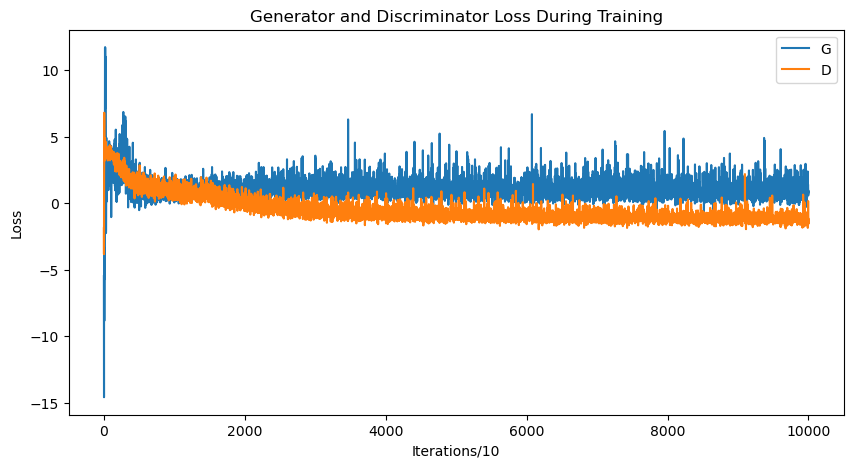

Plot G and D Learning Rate



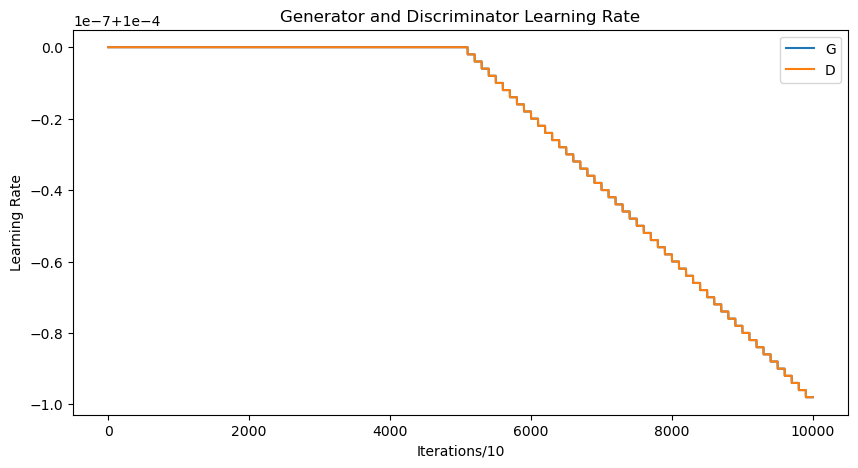

In [ ]:
# Resume training from this step
# resume_iters=20000

# Change params
# num_iters=100    #number of total iterations for training D
# num_iters_decay=50  # number of iterations for decaying lr
# lr_update_step=10 # update lr


# Solver for training AttentionGAN
solver = Solver(ffhq128_loader)

print("Training...")
solver.train()



In [ ]:
# Set size of test dataset
# test_size = 100

# Set test mode
mode = 'test'

# Data loader.
batch_size =  16
ffhq128_loader = get_loader(ffhq128_image_dir, attr_path, selected_attrs,
                                ffhq128_crop_size, image_size, batch_size,
                                mode, num_workers)
# Solver for testing AttentionGAN
solver = Solver(ffhq128_loader)

print("Testing...")
solver.test()

Finished preprocessing the Ffhq128 dataset...
313
cuda
Generator(
  (main): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): C

In [ ]:
# Data loader.
ffhq128_loader = None
batch_size =  1024

if dataset in ['Ffhq128']:
    ffhq128_loader = get_loader(ffhq128_image_dir, attr_path, selected_attrs,
                                ffhq128_crop_size, image_size, batch_size,
                                mode, num_workers)


# Results:

Using the original architecture with 6 classes, the image quality was acceptable, although the image for the youngest and oldest age group were very heavily distorted, which is likely due to their low frequency in the distribution of our dataset

Changing the architecture from InstanceNorm2d to BatchNorm2d did not reduce the quality of the image. However, the model was not able to distinguish different age groups, leading all iamges to look very similar to each other across all age groups.

Adding 3 more classes significantly increases the training time (almost doubles it). Due to the time constaint, I was able to only train it for over 25 epochs instead of the original 50 epoch. Compared to the images generated by the original model after 25 epoch, the quality of the images suprisingly became worse with noticable anomalies, but I think the result would have been better if it was trained a little longer.